# Pitchfork Data Analysis
Analysis of data from Pitchfork, an online music magazine hosting reviews of songs spanning multiple genres. There are over 18,000 reviews for songs from 1959 to 2017. This analysis was inspired by the following questions:
1. How have review scores changed over time? 
2. Is there any favoritism towards certain record labels?
3. What factors are most important when determining whether a song gets "best new music"?

## Preliminaries
We begin with downloading relevant packages and connecting to the SQL database harboring the different tables.

In [1]:
# Downloading relevant packages
import numpy as np
import pandas as pd
import datetime as dt
import scipy.stats as ss
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.ticker as ticker
import seaborn as sns
import sqlite3

In [2]:
# Connecting to sql database using sqlite3
con = sqlite3.connect("database.sqlite")
# Creating cursor to point to tables within the database
cur = con.cursor()

## Exploration
We now move on to explore the data more closely, creating Pandas DataFrames from the SQL database whenever necessary.

In [3]:
# Let's begin by looking at artists, genre, release and review dates, and scores
# Goal for query is to only include title with release years,
# and if genre is unlisted, replace with "other"
pitchfork_sql = cur.execute(
    """
    SELECT R.reviewid AS review_id, title, artist, 
           CASE
                WHEN GLY.genre IS NULL THEN "other"
                ELSE GLY.genre
           END AS genre, GLY.label AS record_label, GLY.release_year, 
           pub_date AS review_date, best_new_music, score
    FROM reviews R
    LEFT JOIN (
        SELECT G.reviewid, G.genre, LY.year as release_year, LY.label 
        FROM genres G
        LEFT JOIN (
            SELECT Y.reviewid, L.label, Y.year 
            FROM labels L
            LEFT JOIN years Y ON L.reviewid = Y.reviewid
        ) AS LY
        ON G.reviewid = LY.reviewid
    ) AS GLY 
    ON R.reviewid = GLY.reviewid
    WHERE release_year IS NOT NULL
    AND record_label IS NOT "" 
    ORDER BY release_year ASC
    """
)
# Transform queried table to pandas dataframe
pitchfork_df = pd.DataFrame(
    data = pitchfork_sql.fetchall(),
    columns = ["review_id", "title", "artist", "genre", "record_label", "release_year", "review_date", "best_new_music", "score"]
)
# Looking at top rows
pitchfork_df.head()

,review_id,title,artist,genre,record_label,release_year,review_date,best_new_music,score
0,13258,drums of passion,babatunde olatunji,global,sony,1959,2009-07-13,1,8.2
1,21797,at last!,etta james,jazz,jackpot records,1960,2016-04-25,0,9.0
2,17864,i hear a new world,joe meek,other,poppydisc,1960,2013-04-05,0,8.3
3,1544,this is our music,ornette coleman,jazz,atlantic,1960,2002-03-25,0,9.4
4,22525,folk time,hart valley drifters,folk/country,ato,1962,2016-11-15,0,7.8


In [4]:
# Changing review_date to datatimes
pitchfork_df["review_date"] = pd.to_datetime(pitchfork_df["review_date"])
# Removing single NaN value
pitchfork_df.dropna(inplace = True)
# Looking at variable information
pitchfork_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25277 entries, 0 to 25317
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   review_id       25277 non-null  int64         
 1   title           25277 non-null  object        
 2   artist          25277 non-null  object        
 3   genre           25277 non-null  object        
 4   record_label    25277 non-null  object        
 5   release_year    25277 non-null  int64         
 6   review_date     25277 non-null  datetime64[ns]
 7   best_new_music  25277 non-null  int64         
 8   score           25277 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(3), object(4)
memory usage: 1.9+ MB


In [5]:
# Defining a function to help with sorting record labels into buckets
def song_buckets(num_songs_label: int) -> int:
    """
    Function that takes in the value of songs from a single record label and outputs corresponding bucket
        Input:
            num_songs_label (int): number of songs a certain label has
        Output:
            Integer value corresponding to bucket [1, 2-10, 10-100, 100+] label is in
    """
    if num_songs_label == 1:
        return 0
    elif num_songs_label > 1 and num_songs_label < 5:
        return 1
    elif num_songs_label >= 5 and num_songs_label < 25:
        return 2
    elif num_songs_label >= 25 and num_songs_label < 100:
        return 3
    else:
        return 4

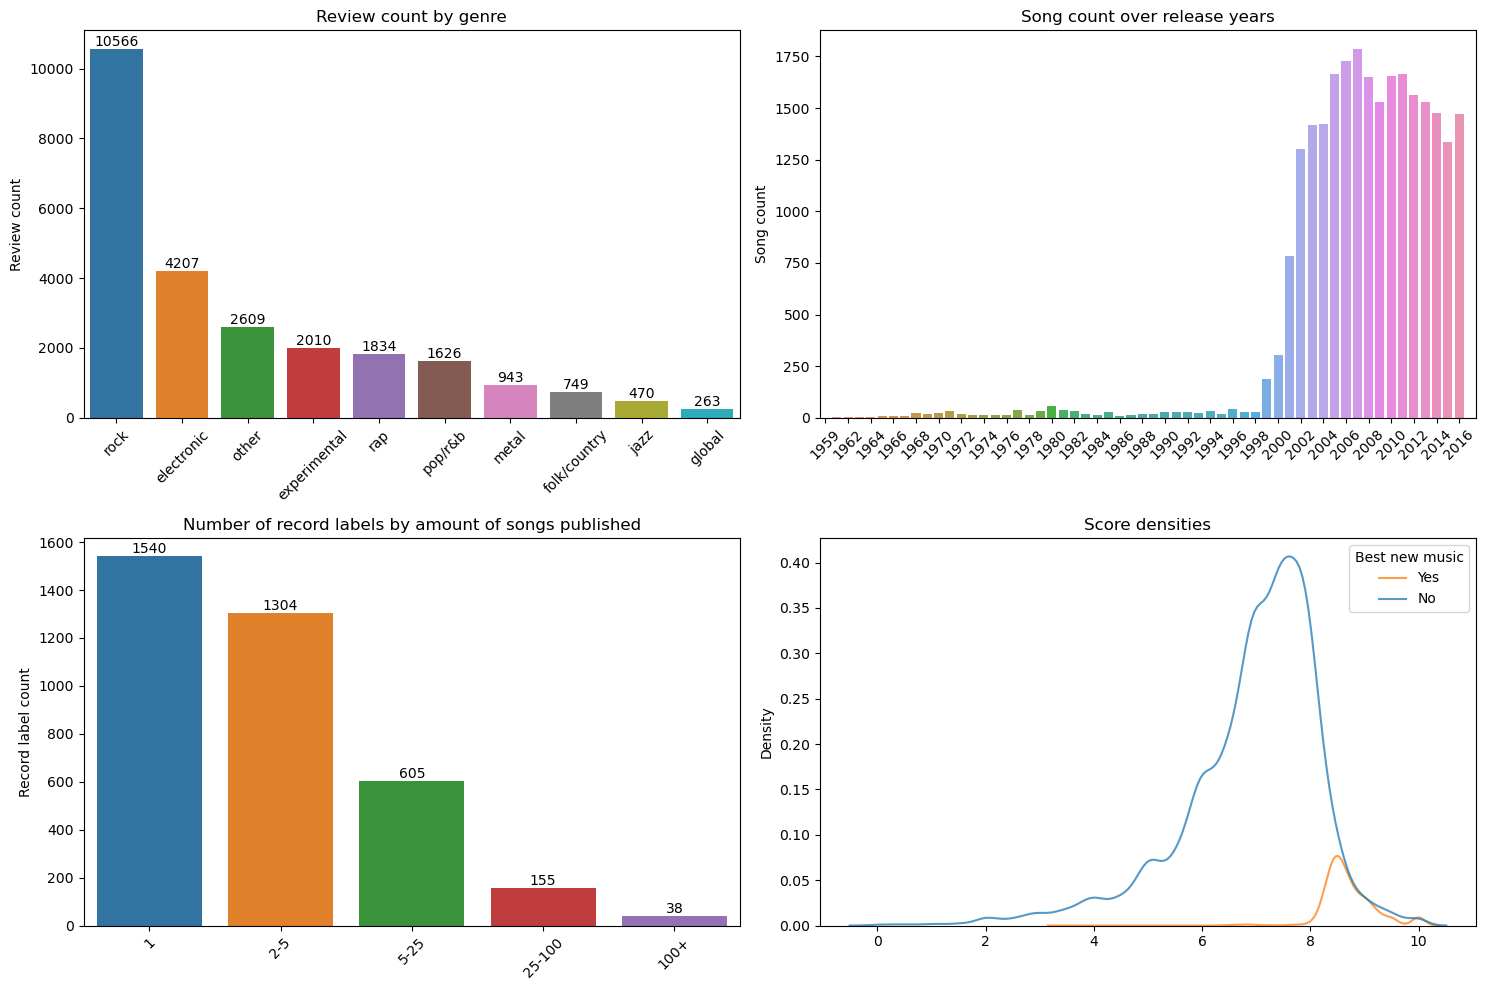

In [6]:
# Looking at barplots of reviews per categories
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows = 2, ncols = 2, figsize = (15,10))
# Beginning with reviews by genre, sorted in descending order
genres_sorted = pitchfork_df.groupby("genre").count().rename(columns = {"score": "Review count"})["Review count"].sort_values(ascending = False)
genres_sorted_categories = genres_sorted.index
ax0p = sns.barplot(
    data = pitchfork_df, 
    x = genres_sorted_categories, 
    y = genres_sorted,
    ax = ax0
)
# This allows us to add number values on top of bars
for i in ax0p.containers:
    ax0p.bar_label(i,)
ax0.set_xticklabels(genres_sorted_categories, rotation = 45)
ax0.set_xlabel("")
ax0.set_title("Review count by genre")
# Continuing with reviews by song release year, sorted by chronological order 
years_sorted = pitchfork_df.groupby("release_year").count().rename(columns = {"score": "Song count"})["Song count"]
years_sorted_categories = years_sorted.index
sns.barplot(
    data = pitchfork_df, 
    x = years_sorted_categories, 
    y = years_sorted,
    ax = ax1
)
ax1.set_xticks(np.arange(len(years_sorted))[::2])
ax1.set_xticklabels(years_sorted_categories[::2], rotation = 45)
ax1.set_xlabel("")
ax1.set_title("Song count over release years")
# Following with number of record labels with [1, 2-5, 5-25, 25-100, 100+] number of songs with reviews
# Here we first have to group the number of songs by record labels
labels = pitchfork_df.groupby("record_label").count().rename(columns = {"score": "num_songs"})[["num_songs"]]
labels_categories = labels.index
# Next we apply our function to convert to categorical groups 0, 1, 2, 3, and 4
labels_bucketed = pd.DataFrame(labels["num_songs"].map(lambda x: song_buckets(x)))
# Next we reinsert the labels so as to be able to group the dataframe again
labels_bucketed["labels"] = labels_categories
# Grouping number of record labels by number of songs they have published
labels_sorted = labels_bucketed.groupby("num_songs").count()["labels"]
labels_sorted_categories = labels_sorted.index
ax2p = sns.barplot(
    x = labels_sorted_categories, 
    y = labels_sorted,
    ax = ax2
)
for i in ax2p.containers:
    ax2p.bar_label(i,)
ax2.set_xticklabels([])
ax2.set_xlabel("")
ax2.set_ylabel("Record label count")
ax2.set_title("Number of record labels by amount of songs published")
ax2.set_xticklabels(["1", "2-5", "5-25", "25-100", "100+"], rotation = 45)
# Finally, histogram of scores, differentiating between best new music or not
sns.kdeplot(data = pitchfork_df,
            x = "score",
            hue = "best_new_music",
            alpha = 0.75,
            fill = False,
            ax = ax3
)
ax3.legend(["Yes", "No"], title = "Best new music")
ax3.set_xlabel("")
ax3.set_title("Score densities")
plt.tight_layout()
plt.show()

In [7]:
# Checking to see if there is a statistically significant difference between score density means
t, p = ss.ttest_ind(
       a = pitchfork_df[pitchfork_df["best_new_music"] == 1]["score"],
       b = pitchfork_df[pitchfork_df["best_new_music"] == 0]["score"],
       equal_var = False
)
print(f"The means are different: {p < 0.05}")

The means are different: True


We see immediately that rock is the most represented genre in Pitchfork by a substantial margin. Given that other genres have much fewer songs with reviews, it might be beneficial to merge similar genres together to reduce the feature space if we would like to train a model. On the other hand, it would be interesting to see average scores and how reviews have changed over time for each of these genres and if there is an overrepresentation of certain genres in the "best new music" category.

In terms of song count over time, we see that most reviews are of songs that were released from the early 2000's onwards. It might be best to group songs before 2001 together to reduce the feature space. Checking scores per song release year might be interesting, as well as comparing release dates with review dates to see if there are trends or biases that appear.

Regarding the record labels, most record labels are small, releasing 1-5 songs with reviews. It would be interesting to compare the average scores of the more represented record labels with those of smaller ones to see if record labels are important when deciding whether a song received "best new music" or not.

Finally, songs that win "best new music" tend to have higher scores than those that do not, although there is some overlap. It shows that scores are not the only factor going into recieving the award.

## 1. How have review scores changed over time?

We will begin exploring how review scores differ as the difference between review year and relase year increases.

In [12]:
# Looking at review scores over time
# We begin by querying score averages over month-years
sub_sql = cur.execute(
    """
    SELECT 
        AVG(score),
        STRFTIME("%Y-%m", pub_date) as YM
    FROM reviews
    GROUP BY YM
    ORDER BY YM ASC
    """
)
sub_df = pd.DataFrame(
    data = sub_sql.fetchall(),
    columns = ["Average scores", "Year-month"]
)

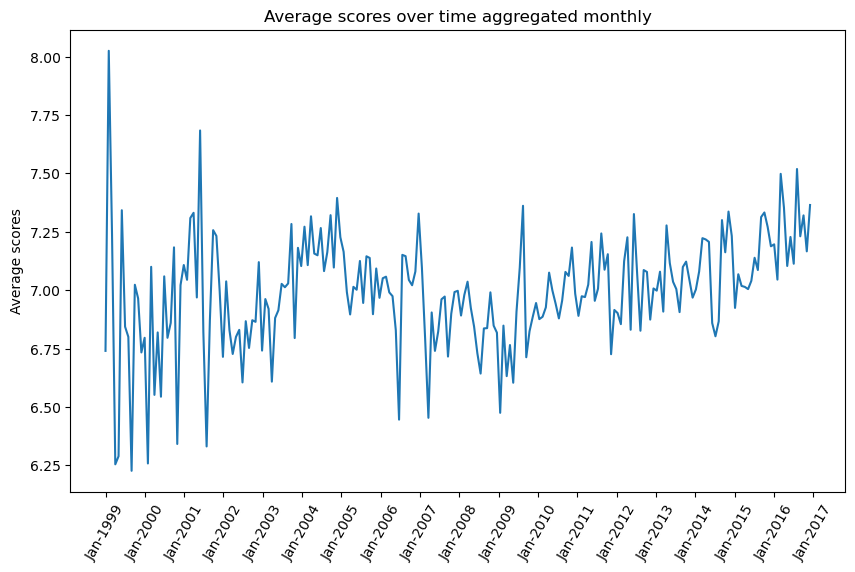

In [30]:
plt.figure(figsize = (10,6))
sns.lineplot(
    data = sub_df,
    x = "Year-month",
    y = "Average scores"
)
plt.title("Average scores over time aggregated monthly")
plt.gca().set_xticks(
    ticks = np.linspace(0,len(sub_df),19),
    labels = ["Jan-" + str(int(x)) for x in np.linspace(1999, 2017, 19)],
    rotation = 60
)
plt.xlabel("")
plt.show()

In [9]:
# Looking at review scores over time
# We begin by creating new columns for review year
pitchfork_df["review_year"] = pitchfork_df["review_date"].dt.year
pitchfork_df.head()

,review_id,title,artist,genre,record_label,release_year,review_date,best_new_music,score,review_year
0,13258,drums of passion,babatunde olatunji,global,sony,1959,2009-07-13,1,8.2,2009
1,21797,at last!,etta james,jazz,jackpot records,1960,2016-04-25,0,9.0,2016
2,17864,i hear a new world,joe meek,other,poppydisc,1960,2013-04-05,0,8.3,2013
3,1544,this is our music,ornette coleman,jazz,atlantic,1960,2002-03-25,0,9.4,2002
4,22525,folk time,hart valley drifters,folk/country,ato,1962,2016-11-15,0,7.8,2016


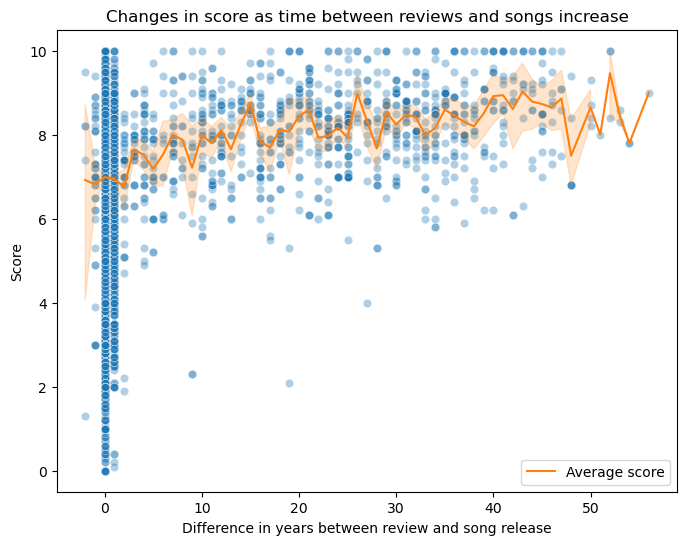

In [10]:
# Visualization of review score averages as time difference increases
pitchfork_df["review_release_difference"] = pitchfork_df["review_year"] - pitchfork_df["release_year"]
fig = plt.figure(figsize = (8,6))
sns.scatterplot(
    pitchfork_df,
    x = pitchfork_df["review_release_difference"],
    y = "score",
    alpha = 0.35
)
sns.lineplot(
    pitchfork_df,
    x = pitchfork_df["review_release_difference"],
    y = "score",
    errorbar = "ci",
    color = "tab:orange",
    label = "Average score"
)
plt.xlabel("Difference in years between review and song release")
plt.ylabel("Score")
plt.title("Changes in score as time between reviews and songs increase")
plt.show()

We can see that, generally, reviews for relatively older songs seem to be higher than those for those closer in time. This could be reflective of biases stemmed from nostalgia, for example. However, it is important to note that there are significantly less songs released before the 21st century. We can also take a look at what genres got the most reviews and best average scores over the years.

In [25]:
# Creating animation update function that produces new bar plots each frame for genre count
def update_animation_count(year: int) -> None:
    """
    Function that updates animation and then clears axis
    
        Parameters:
            year (int): The year to change to in the animation (must be in pivot table column list)
    
        Returns:
            None: Just updates animation, no need to output anything
    """
    bars = count_pivot[year].sort_values(ascending = False)
    xaxis_ul = bars.max()*1.1
    ax.set_xlim(0, xaxis_ul)
    ax.clear()
    ax.invert_yaxis()
    ax.set_xlabel("Count")
    ax.set_title(f"Pitchfork review count by genre in {year}")
    colors = ["#FFA500", "#FFC100", "#FFD700"]
    ax.barh(bars.index[:3], bars[:3], color = colors, height = 0.7)
    ax.barh(bars.index[3:], bars[3:], color = "tab:blue", height = 0.7)
    

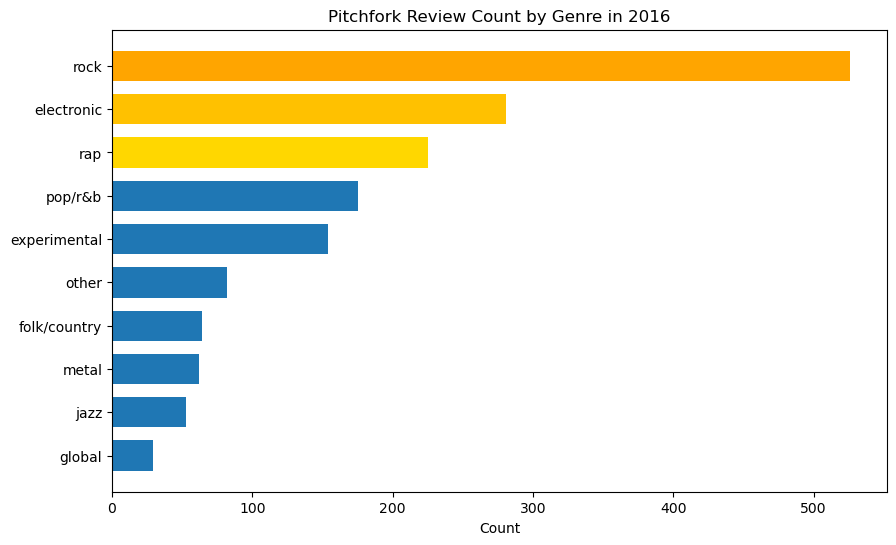

In [26]:
# First we create a pivot table for genre count for each year
count_pivot0 = pd.pivot_table(pitchfork_df, values = "score", index = "genre", columns = "review_year", aggfunc = "count")
count_pivot = count_pivot0.drop(labels = 2017, axis = 1)
count_years = count_pivot.columns
# Now we create the animation
fig, ax = plt.subplots(figsize = (10,6))
animation = FuncAnimation(fig, 
                          update_animation,
                          frames = count_years,
                          repeat = True,
                          interval = 100)
from IPython.display import HTML
HTML(animation.to_jshtml())

In [27]:
# Creating animation update function that produces new bar plots each frame for mean genre scores
def update_animation_score(year: int) -> None:
    """
    Function that updates animation and then clears axis
    
        Parameters:
            year (int): The year to change to in the animation (must be in pivot table column list)
    
        Returns:
            None: Just updates animation, no need to output anything
    """
    bars = score_pivot[year].sort_values(ascending = False)
    xaxis_ul = bars.max()*1.1
    ax.set_xlim(0, xaxis_ul)
    ax.clear()
    ax.invert_yaxis()
    ax.set_xlabel("Mean score")
    ax.set_title(f"Pitchfork review count by genre in {year}")
    colors = ["#FFA500", "#FFC100", "#FFD700"]
    ax.barh(bars.index[:3], bars[:3], color = colors, height = 0.7)
    ax.barh(bars.index[3:], bars[3:], color = "tab:blue", height = 0.7)

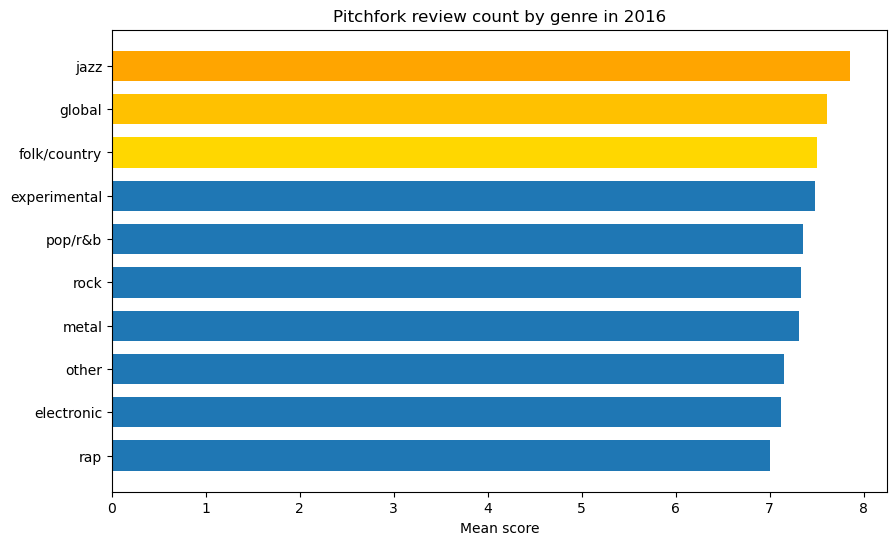

In [28]:
# We now create a pivot table for genre score means for each year
score_pivot0 = pd.pivot_table(pitchfork_df, values = "score", index = "genre", columns = "review_year", aggfunc = "mean")
score_pivot = score_pivot0.drop(labels = 2017, axis = 1)
score_years = score_pivot.columns
# Now we create the animation
fig, ax = plt.subplots(figsize = (10,6))
animation = FuncAnimation(fig, 
                          update_animation_score,
                          frames = score_years,
                          repeat = True,
                          interval = 100)
from IPython.display import HTML
HTML(animation.to_jshtml())

## 2. Is there any favoritism towards certain record labels?
We will take a look at how review scores change per record label type (depending on amount of songs released).

In [10]:
# Adding record label buckets into dataset by creating map
record_label_buckets_map = {}
for label, bucket in zip(labels_bucketed["labels"].values, labels_bucketed["num_songs"].values):
    record_label_buckets_map[label] = bucket
# Using map function
pitchfork_df["record_label_type"] = pitchfork_df["record_label"].map(record_label_buckets_map)
pitchfork_df.head()

,review_id,title,artist,genre,record_label,release_year,review_date,best_new_music,score,review_year,review_release_difference,record_label_type
0,13258,drums of passion,babatunde olatunji,global,sony,1959,2009-07-13,1,8.2,2009,50,3
1,21797,at last!,etta james,jazz,jackpot records,1960,2016-04-25,0,9.0,2016,56,1
2,17864,i hear a new world,joe meek,other,poppydisc,1960,2013-04-05,0,8.3,2013,53,1
3,1544,this is our music,ornette coleman,jazz,atlantic,1960,2002-03-25,0,9.4,2002,42,4
4,22525,folk time,hart valley drifters,folk/country,ato,1962,2016-11-15,0,7.8,2016,54,3


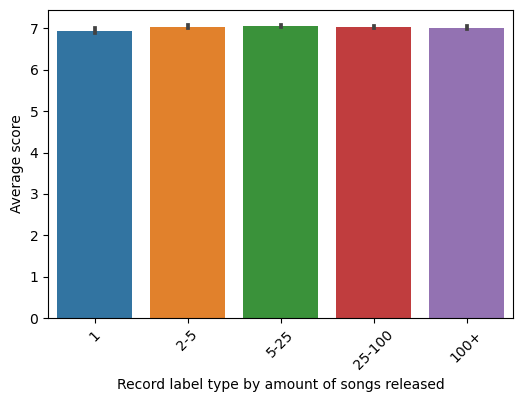

In [11]:
# Looking at average scores by record label type
plt.figure(figsize = (6,4))
sns.barplot(
    pitchfork_df,
    x = "record_label_type",
    y = "score"
)
plt.xlabel("Record label type by amount of songs released")
plt.ylabel("Average score")
plt.xticks([0, 1, 2, 3, 4], ["1", "2-5", "5-25", "25-100", "100+"], rotation = 45)
plt.show()

There is no clear difference between groups here. It might instead be more fruitful to see what the record labels with most songs with reviews are, and if these have a majority of best new music awards. This might be more indicative of favoritism, if there is any, than score by type of record label.

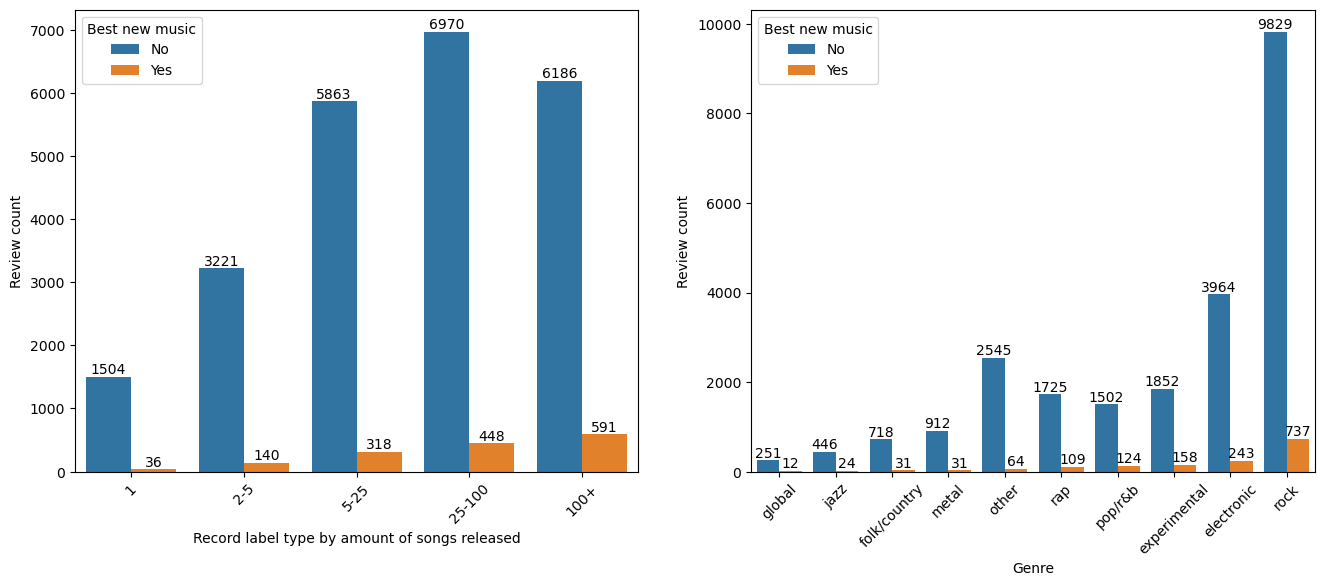

In [12]:
# Looking at number of "best new music" by record label type as well as genre
fig, (ax0, ax1) = plt.subplots(nrows = 1, ncols = 2, figsize = (16,6))
ax0p = sns.countplot(
    pitchfork_df,
    x = "record_label_type",
    hue = "best_new_music",
    ax = ax0
)
ax0.set_xlabel("Record label type by amount of songs released")
ax0.set_ylabel("Review count")
ax0.set_xticks([0, 1, 2, 3, 4], ["1", "2-5", "5-25", "25-100", "100+"], rotation = 45)
ax0.legend(["No", "Yes"], title = "Best new music")
for i in ax0p.containers:
    ax0p.bar_label(i,)
# Review count by genre
bnm_ordered_genres = list(pitchfork_df.groupby("genre").sum(numeric_only = True)["best_new_music"].sort_values(ascending = True).index)
ax1p = sns.countplot(
    pitchfork_df,
    x = "genre",
    hue = "best_new_music",
    order = bnm_ordered_genres,
    ax = ax1
)
ax1.set_xlabel("Genre")
ax1.set_ylabel("Review count")
ax1.set_xticklabels(bnm_ordered_genres, rotation = 45)
ax1.legend(["No", "Yes"], title = "Best new music")
for i in ax1p.containers:
    ax1p.bar_label(i,)
plt.show()

It seems like record labels with the most songs represented in the dataset also have the most best new music awards. On the other hand, it seems like rock songs tend to get the best new music award more than other genres. This could be partially explained by the sheer count of reviews in the groups, however given that there are classes with more best new music awards but less overall reviews indicates that there might be another effect at play.

## 3. What factors are most important when determining whether a song gets "best new music"?
Now we will use what we have discovered to attempt to identify the most important features that lead songs to gain the best new music title. We looked at scores, difference between review and release years, types of label based on the number of songs they released with reviews, and genre. Let's pick those as the main explanatory variables for our dependent variables, best new music.

In [73]:
# Importing necessary functions and packages
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.inspection import partial_dependence, PartialDependenceDisplay

In [28]:
# Defining explanatory variables (X) and dependent variable (y)
X = pitchfork_df[["score", "review_release_difference", "record_label_type", "genre"]]
y = pitchfork_df["best_new_music"]

In [29]:
# Encoding genre using dummy variables
X = pd.get_dummies(X, drop_first = True)
# Normalizing numeric variables
X[["score", "review_release_difference"]] = StandardScaler().fit_transform(X[["score", "review_release_difference"]])
X = X.rename(columns = {"score": "normed_score", "review_release_difference": "normed_review_release_difference"})
X.head()

,normed_score,normed_review_release_difference,record_label_type,genre_experimental,genre_folk/country,genre_global,genre_jazz,genre_metal,genre_other,genre_pop/r&b,genre_rap,genre_rock
0,0.888895,9.622139,3,0,0,1,0,0,0,0,0,0
1,1.496893,10.799903,1,0,0,0,1,0,0,0,0,0
2,0.964894,10.211021,1,0,0,0,0,0,1,0,0,0
3,1.800892,8.051787,4,0,0,0,1,0,0,0,0,0
4,0.584895,10.407315,3,0,1,0,0,0,0,0,0,0


In [30]:
# Using logistic regression on whole data set to identify significant variables
logreg = sm.Logit(y, X).fit()
logreg.summary()

Optimization terminated successfully.
         Current function value: 0.199777
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         best_new_music   No. Observations:                25277
Model:                          Logit   Df Residuals:                    25265
Method:                           MLE   Df Model:                           11
Date:                Tue, 31 Oct 2023   Pseudo R-squ.:                  0.1266
Time:                        12:32:20   Log-Likelihood:                -5049.8
converged:                       True   LL-Null:                       -5782.0
Covariance Type:            nonrobust   LLR p-value:                1.436e-307
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
normed_score                         2.2110      0.050     44.248      0.000       2.113       2.309
normed_review_release_difference    -0.0140      0.019     -0.755      0.450      -0.050       0.022
record_label_type                   -0.7605      0.017    -43.705      0.000      -0.795      -0.726
genre_experimental                  -2.1645      0.100    -21.669      0.000      -2.360      -1.969
genre_folk/country                  -2.7540      0.197    -13.959      0.000      -3.141      -2.367
genre_global                        -3.0206      0.312     -9.687      0.000      -3.632      -2.409
genre_jazz                          -3.0560      0.234    -13.056      0.000      -3.515      -2.597
genre_metal                         -2.8131      0.198    -14.243      0.000      -3.200      -2.426
genre_other                         -3.5939      0.138    -26.028      0.000      -3.865      -3.323
genre_pop/r&b                       -1.9478      0.111    -17.474      0.000      -2.166      -1.729
genre_rap                           -2.2652      0.116    -19.477      0.000      -2.493      -2.037
genre_rock                          -1.9811      0.057    -34.457      0.000      -2.094      -1.868
====================================================================================================
"""

In [32]:
# We can most likely remove the review_release_difference variable, 
# as it is not significant to best_new_music
X1 = X.drop(labels = ["normed_review_release_difference"], axis = 1)
# Splitting training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size = 0.2, stratify = y)

In [57]:
# Creating function to append model results to a table for next and potential future models
def make_results(model_name: str, y_pred: list, y_true: list):
    """
    Function that produces a list of classification metrics given real outcomes and a model's predicted outcomes
    
        Parameters:
            model_name (str): Name of model that achieved predicted outcomes
            y_pred (list): Predicted outcomes 
            y_true (list): Real outcomes
        
        Returns:
            A pandas DataFrame of common classification metrics applied on model outcomes
    """
    metric_list = [model_name]
    metrics = [accuracy_score, precision_score, recall_score, f1_score, roc_auc_score]
    metric_labels = ["Model", "Accuracy", "Precision", "Recall", "F1", "ROC AUC"]
    for metric in metrics:
        metric_list += [metric(y_pred, y_true)]
    return pd.DataFrame(metric_list, metric_labels).T

In [60]:
# Creating Random Forest model and setting up hyperparamter grid search
# We are using a 5-fold cross validation
scoring = {"accuracy", "precision", "recall", "f1", "roc_auc"}
refit = "f1"
rf = RandomForestClassifier(random_state = 0)
rf_param_grid = {"max_depth": [5, 10, 50, None],
                 "min_samples_split": [2, 5, 8, 10],
                 "max_features": ["sqrt", "log2", None],
                 "n_estimators": [50, 100, 500]}
rf_cv = GridSearchCV(rf,
                     cv = 5,
                     param_grid = rf_param_grid, 
                     scoring = scoring, 
                     refit = refit,
                     n_jobs = 10,
                     verbose = True)

In [63]:
%%time
# Running grid search on training set
# Some errors will appear regarding computation of metrics, don't worry about them
rf_cv.fit(X_train, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


/Users/Benjamin/opt/anaconda3/envs/bmnn/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Benjamin/opt/anaconda3/envs/bmnn/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Benjamin/opt/anaconda3/envs/bmnn/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Benjamin/opt/anaconda3/envs/bmnn/

CPU times: user 2.74 s, sys: 895 ms, total: 3.63 s
Wall time: 2min 13s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0), n_jobs=10,
             param_grid={'max_depth': [5, 10, 50, None],
                         'max_features': ['sqrt', 'log2', None],
                         'min_samples_split': [2, 5, 8, 10],
                         'n_estimators': [50, 100, 500]},
             refit='f1',
             scoring={'precision', 'accuracy', 'recall', 'f1', 'roc_auc'},
             verbose=True)

In [47]:
# Best random forest estimator and classification results
print(rf_cv.best_estimator_)
rf_pred = rf_cv.best_estimator_.predict(X_test)
rf_metrics = make_results("Random Forest", rf_pred, y_test)
rf_metrics

RandomForestClassifier(max_depth=50, max_features=None, min_samples_split=5,
                       n_estimators=50, random_state=0)


,Model,Accuracy,Precision,Recall,F1,ROC AUC
0,Random Forest,0.946203,0.47557,0.568093,0.51773,0.767272


These scores are not very favorable for this model. Precision, recall, and therefore F1 scores are all low, representing a mislabeling of data points. High accuracy and somewhat high ROC AUC do not necessarily represent a well-trained model. If we look at the data composition, there are many more music reviews that did not give the best new music title than those that did, meaning that the model will perform very well even if it incorrectly labels most data points as not deserving of best new music. We can also see this represented in a confusion matrix.

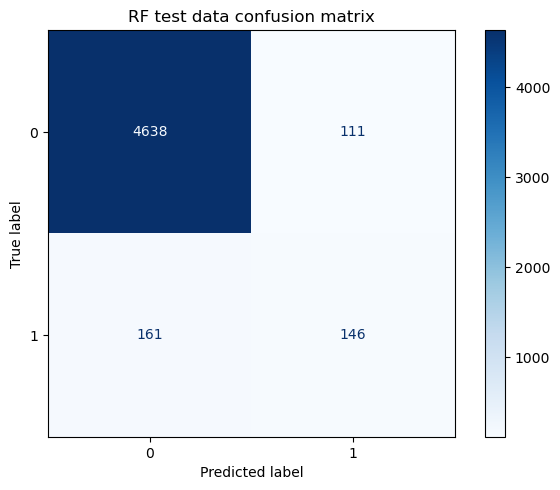

In [64]:
# Confusion matrix for random forest results
rf_test = rf_cv.best_estimator_.predict(X_test)
rf_conf_mat = confusion_matrix(y_pred = rf_test, y_true = y_test, labels = rf_cv.best_estimator_.classes_)
rf_conf_mat_disp = ConfusionMatrixDisplay(rf_conf_mat, display_labels = rf_cv.best_estimator_.classes_)

rf_conf_mat_disp.plot(cmap = "Blues", values_format='')
plt.tight_layout()
plt.title("RF test data confusion matrix")
plt.show()

We thus cannot put too much trust in this model, but for the purposes of this project, let's continue by taking a look at the important and partial dependence plots to get an idea as to what this model believes are the most important factors when deciding whether a review will granted best new music or not.

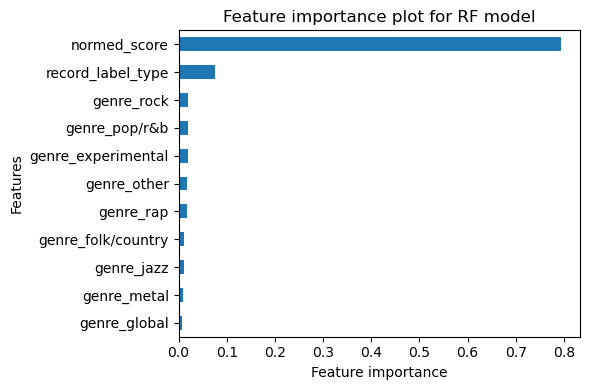

In [68]:
# Plotting feature importances 
importances = rf_cv.best_estimator_.feature_importances_
forest_importances = pd.Series(importances, index=X1.columns).sort_values(ascending=True)
plt.figure(figsize = (6,4))
forest_importances.plot.barh()
plt.ylabel("Features")
plt.xlabel("Feature importance")
plt.title("Feature importance plot for RF model")
plt.tight_layout()
plt.show()

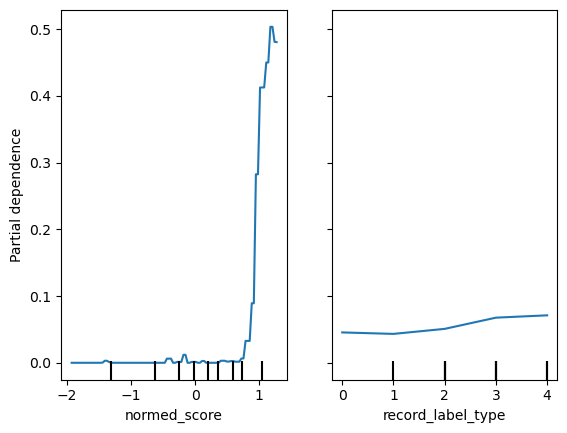

In [85]:
# Plotting partial dependence for first two variables
PartialDependenceDisplay.from_estimator(rf_cv.best_estimator_, X1, [0, 1])
plt.show()

So, it seems like score and record label type are the two most important variables in determining best new music status, with the first being more important than the second. From the PDP, we see that the model predicts more best new music outcomes when score is greater than the average (around one standard deviation), and also when the songs are from record labels with many songs (25+). We can thus conclude that